## การออกแบบตัวควบคุมป้อนกลับสถานะและตัวสังเกต (พลานต์ HDM)

วัตถุประสงค์ของโน๊ตบุกนี้คือศึกษาเครื่องมือซอฟต์แวร์ Drake เบื้องต้น โดยเน้นการนิยามระบบพลวัตเชิงเน้น
และสร้างแผนภาพสำหรับการจำลอง ประกอบด้วยระบบ 3 ประเภท คือ ระบบสถิต (static) ระบบเวลาต่อเนื่อง 
(continuous-time) และระบบเวลาวิยุต (discrete-time)

**หมายเหตุ :** สำหรับงานด้านระบบควบคุมอย่างง่ายเช่นการวางโพล เราจะยังใช้ไลบรารี Python Control Systems 
จนกระทั่งได้อัตราขยายป้อนกลับสถานะและตัวสังเกตแล้ว จึงสร้างคลาสของ Drake และแผนภาพสำหรับการจำลอง

In [72]:
#!pip install control==0.10.0

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl

In [74]:
ctl.__version__

'0.10.0'

### โจทย์ปัญหา 

เราต้องการออกแบบระบบป้อนกลับสถานะและตัวสังเกตและจำลองระบบสำหรับพลานต์ตัวขับเคลื่อนฮาร์มอนิก
ที่ใช้มาก่อนหน้านี้ โดยมีแผนภาพแสดงในรูปที่ 1

!["fig 1"](https://raw.githubusercontent.com/dewdotninja/sharing-github/master/lsid_fig5.jpg)

รูปที่ 1 แผนภาพของข้อต่อหุ่นยนต์เชื่อมต่อกับตัวขับเคลื่อนฮาร์มอนิก

เมื่อแทนค่าพารามิเตอร์ในเซลล์ด้านล่างจะได้ฟังก์ชันถ่ายโอนเท่ากับ

$$
P(s) = \frac{100000}{0.3s^5 + 3.008s^4 + 3400.08s^3 + 4056s^2 + 1000060s} \tag{1}
$$


In [75]:
km = 100  # torque constant
kb = 1  # back EMF constant
k = 1000 # torsional stiffness of harmonic drive
r = 10   # gear ratio
R = 1  # armature resistance
L = 0.1 # armature inductance
Jm = 1  #  motor inertia
Bm = 0.01  # motor shaft friction
Jl = 3  # load inertia
Bl = 0.05  # load friction
s = ctl.tf("s")
pl = Jl*s**2 + Bl*s + k
pm = Jm*s**2 + Bm*s + k
P = km*k/(pm*pl*(L*s+R) - k**2*(L*s+R) + r*km*kb*s*pl)
P

TransferFunction(array([100000]), array([3.00000000e-01, 3.00800000e+00, 3.40008005e+03, 4.05600050e+03,
       1.00006000e+06, 0.00000000e+00]))

ตรวจสอบแผนภาพโบเดของพลานต์ 

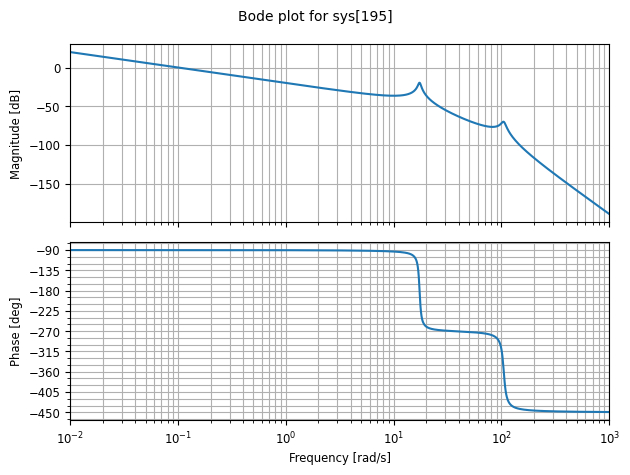

In [76]:
_ = ctl.bode_plot(P,dB=True, omega_limits=(0.01,1000))

แปลงพลานต์นี้เป็นการบรรยายปริภูมิสถถานะ และดึงค่าเมทริกซ์ A,B,C,D เพื่อใช้งานได้ง่าย

In [77]:
Pss = ctl.tf2ss(P)
A,B,C,D = ctl.ssdata(Pss)
print("A = {}".format(A))
print("B = {}".format(B))
print("C = {}".format(C))
print("D = {}".format(D))

A = [[-1.00266667e+01 -1.13336002e+04 -1.35200017e+04 -3.33353333e+06
  -0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00]]
B = [[1.]
 [0.]
 [0.]
 [0.]
 [0.]]
C = [[     0.              0.              0.              0.
  333333.33333333]]
D = [[0.]]


เราต้องแน่ใจว่าแต่ละสถานะในเวกเตอร์เป็นค่าที่สามารถวัดได้และเรียงตามต้องการ เช่น 
ค่าองศา ความเร็ว ฯฃฯ เพื่อที่จะติดตั้งเซนเซอร์ได้ถูกต้อง แต่ในการแปลงโดยใช้เครื่องมือซอฟต์แวร์อาจมีความแตกต่างกันไป 
นอกจากนั้นในพลานต์อันดับ 5 นี้อาจมีสถานะที่ไม่มีความหมายทางกายภาพและไม่สามารถวัดได้ในทางปฏิบัติ 
ดังนั้นในโจทย์นี้เราเลือกจะออกแบบตัวสังเกตและใช้สถานะที่ประมาณค่าเป็นตัวป้อนกลับ 
ทำให้แผนภาพเป็นตัวควบคุมป้อนกลับเอาต์พุตดังแสดงในรูปที่ 2

!["fig 2"](https://raw.githubusercontent.com/dewdotninja/sharing-github/master/output_feedback.jpg)

รูปที่ 2 แผนภาพการควบคุมแบบป้อนกลับเอาต์พุต

จากตัวอย่างนี้ จะละทิ้งบล็อกการจัดรูปคำสั่งอ้างอิง $G$ เพื่อความง่าย ดังนั้นหน้าที่ของเราคือออกแบบอัตราขยายป้อนกลับสถานะ 
$K$ และอัตราขยายของตัวสังเกต $L$ ซึืงเป็นบล็อกอัตราขยายสถิต การออกแบบในแต่ละส่วนสามารถทำได้เป็นอิสระจากกัน

ในขั้นแรกพิจารณาการป้อนกลับสถานะ โดยอาศัยวิธีการใน 
[module 5](https://github.com/dewdotninja/control_python/blob/main/ceb_m5.ipynb)
เริ่มจากตรวจสอบว่าพลานต์เป็นแบบควบคุมได้ กล่าวคือเมทริกซ์ควบคุมได้มีค่าลำดับชั้น (rank) เต็ม (เท่ากับจำนวนสถานะ)


In [78]:
np.linalg.matrix_rank(ctl.ctrb(A,B))

5

สร้างข้อกำหนดโดยประมาณ (วัตถุประสงค์ของตัวอย่างนี้คือการจำลองระบบโดย Drake 
ดังนั้นจะไม่เคร่งครัดให้ได้ผลตอบสนองตามข้อกำหนดอย่างสมบูรณ์)

1. ค่าการพุ่งเกินน้อยกว่า 5 %
2. ค่าช่วงเวลาขาขึ้นน้อยกว่า 1 วินาที

<p />โดยใช้ความสัมพันธ์ของระบบที่มีลักษณะเด่นอันดับสอง (second-order dominant system) 
เราได้ว่าข้อกำหนด 1 แปลงเป็นอัตราหน่วง $\zeta \ge 0.7$ 
และสำหรับข้อกำหนด 2 จากความสัมพันธ์ $t_r = 1.8/\omega_n$ จะได้ว่า $\omega_n \ge 1.8 $ rad/s 
จากค่าเหล่านี้ สร้างพหุนามลักษณะเฉพาะของระบบวงปิดได้เป็น


\begin{equation} 
\Lambda(s) = s^2 + 2\zeta\omega_ns + \omega_n^2, \tag{2}
\end{equation} 

โดยสำหรับอีก 3 โพลที่เหลือ เลือกวางให้ห่างออกไปทางด้านซ้ายเพื่อมิให้มีผลกระทบต่อผลตอบสนองมากนัก 
ใช้โค้ดนี้ในการสร้างพหุนามลักษณะเฉพาะและคำนวณตำแหน่งโพลที่ต้องการ

In [79]:
zeta = 0.7
wn = 1.8
lamda_s = (s**2 + 2*zeta*wn*s+wn**2)*(s+10)**3
desired_sfb_poles = ctl.zeros(lamda_s) # poles are roots of characteristic polynomial
print(desired_sfb_poles)

[ -9.99994576+0.00000000e+00j -10.00002712+4.69753277e-05j
 -10.00002712-4.69753277e-05j  -1.26      +1.28545712e+00j
  -1.26      -1.28545712e+00j]


ใช้คำสั่ง place() หรือ acker() คำนวณอัตราขยายป้อนกลับสถานะ

In [80]:
K = ctl.place(A, B, desired_sfb_poles)
print(K)

[[ 2.24984891e+01 -1.09546441e+04 -1.16660095e+04 -3.33003970e+06
   3.24167047e+03]]


ตรวจสอบโพลของระบบวงปิดว่าอยู่ในตำแหน่งที่ต้องการ

In [81]:
Tss = ctl.ss(A-B@K, B, C, D)
ctl.poles(Tss)

array([ -9.99992379+0.j        , -10.00013304+0.j        ,
       -10.00509892+0.j        ,  -1.26      +1.28545712j,
        -1.26      -1.28545712j])

ตรวจสอบการออกแบบโดยพล็อตผลตอบสนองขั้นบันได

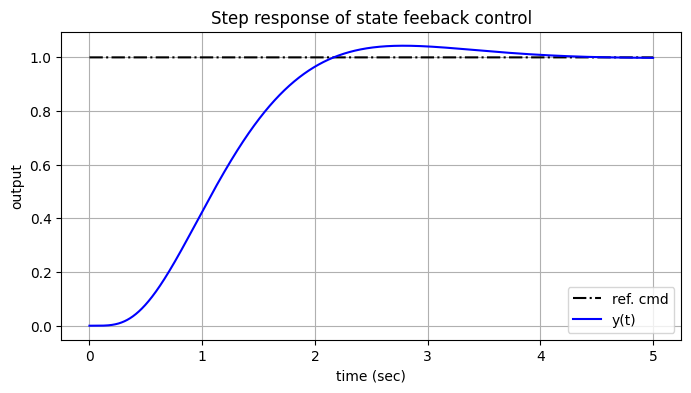

In [82]:
Kf=1/ctl.dcgain(Tss)
tvec = np.arange(0,5.0,0.001)
r = np.ones(tvec.shape)
rc = Kf*np.ones(tvec.shape)
_, y = ctl.forced_response(Tss, tvec, rc)
plt.figure(figsize=(8,4))
plt.plot(tvec,r,'k-.',tvec,y,'b-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(["ref. cmd","y(t)"])
plt.title('Step response of state feeback control')
plt.show()

หากต้องการให้ได้ตามข้อกำหนดโดยเคร่งครัดอาจย้อนไปปรับค่าความถี่ธรรมชาติให้สูงขึ้น 
(ผลเสียคือเอาต์พุตตัวควบคุมสูงขึ้นและอาจเกิดการอิ่มตัว) โดยวัตถุประสงค์ของตัวอย่างนี้ดังที่ได้กล่าว 
เราพอใจกับการออกแบบนี้และดำเนินการต่อในการออกแบบตัวสังเกต 

อันดับแรกคือตรวจสอบว่าพลานต์เป็นแบบสังเกตได้ (observable)

In [83]:
np.linalg.matrix_rank(ctl.obsv(A,C))

5

สามารถออกแบบการวางโพลของตัวสังเกตได้โดยวิธีการเช่นเดียวกับการออกแบบการป้อนกลับสถานะ 
เพียงแต่ใช้เมทริกซ์ A และ C ที่มีการสลับเปลี่ยน โพลของตัวสังเกตจะถูกเลือกให้ห่างไกลออกไปทางด้านซ้ายของระนาบเชิงซ้อน 
เพื่อให้ได้พลวัตการประมาณค่าที่เร็ว

In [84]:
#desired_obs_poles = np.array([-10,-15,-20,-25,-30])
#desired_obs_poles = np.array([-100,-150,-200,-250,-300])
desired_obs_poles = np.array([-1000,-1500,-2000,-2500,-3000])
L = ctl.place(A.T, C.T, desired_obs_poles)
L = L.T
print(L)

[[6.31224652e+10]
 [1.92270090e+08]
 [2.15998194e+05]
 [1.15916124e+02]
 [2.99559037e-02]]


ตรวจสอบว่าโพลระบบวงปิดของตัวสังเกตได้ตำแหน่งตามต้องการ

In [85]:
Oss = ctl.ss(A-L@C, B, C, D)
ctl.poles(Oss)

array([ -996.85902306  +0.j        , -1607.58074218  +0.j        ,
       -1744.40591635  +0.j        , -2823.24111705+279.39060833j,
       -2823.24111705-279.39060833j])

ระบบวงปิดของการควบคุมป้อนกลับสถานะและตัวสังเกตสร้างได้ดังนี้

\begin{equation} 
\left[ \begin{array}{c}
\dot{x} \\
\dot{\tilde{x}} 
\end{array}  \right] = 
\left[ \begin{array} {cc}
A-BK & BK \\
0 & A-LC
\end{array} \right]
\left[ \begin{array}{c}
x \\
\tilde{x}
\end{array} \right] + 
\left[ \begin{array}{c}
BK_f \\
0 
\end{array} \right] u \tag{3}
\end{equation} 

and 

\begin{equation}
y = \Big[C \;\;\; 0\Big]\left[ \begin{array}{c}
x \\
\tilde{x} 
\end{array}  \right] \tag{4} 
\end{equation} 

เขียนโค้ดเพื่อสร้างระบบนี้และจำลองผลตอบสนองขั้นบันได จะพบว่ามีความใกล้เคียงมากกับระบบป้อนกลับสถานะ

In [86]:
A_cl_upper = np.hstack((A-B@K, B@K))
A_cl_lower = np.hstack((np.zeros((5,5)),A - L@C))
A_cl = np.vstack((A_cl_upper,A_cl_lower))
B_cl = np.vstack((B*Kf,np.zeros((5,1))))
C_cl = np.hstack((C,np.zeros((1,5))))
D_cl = [0]
Tss_cl = ctl.ss(A_cl, B_cl, C_cl, D_cl)

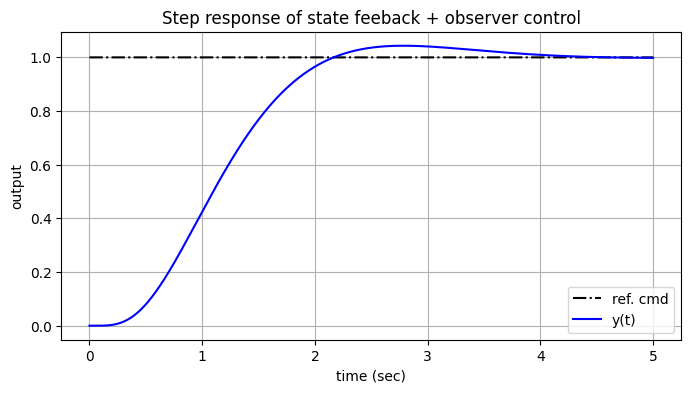

In [87]:
tvec = np.arange(0,5.0,0.001)
r = np.ones(tvec.shape)
_, y_sfo = ctl.step_response(Tss_cl, tvec)
plt.figure(figsize=(8,4))
plt.plot(tvec,r,'k-.',tvec,y_sfo,'b-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(["ref. cmd","y(t)"])
plt.title('Step response of state feeback + observer control')
plt.show()

มาถึงจุดนี้ เราต้องการทดลองแนวทางที่แตกต่างออกไป คือการออกแบบและสร้างพลวัตของตัวสังเกตในระบบเวลาวิยุต 
เหตุผลคือต้องการแสดงว่าสามารถจำลองระบบผสมได้โดยซอฟต์แวร์ Drake ในภายหลัง 

แปลงพลานต์ระบบเวลาต่อเนื่องเป็นระบบเวลาวิยุด โดยเลือกค่าอัตราการสุ่ม Ts

In [88]:
Ts = 0.001 # sampling period
Pdss = ctl.sample_system(Pss,Ts,method='tustin')
Ad,Bd,Cd,Dd = ctl.ssdata(Pdss)
print("Ad = {}".format(Ad))
print("Bd = {}".format(Bd))
print("Cd = {}".format(Cd))
print("Dd = {}".format(Dd))

Ad = [[ 9.84424979e-01 -1.12528739e+01 -1.50685012e+01 -3.30757341e+03
   0.00000000e+00]
 [ 9.92212490e-04  9.94373563e-01 -7.53425061e-03 -1.65378670e+00
   0.00000000e+00]
 [ 4.96106245e-07  9.97186782e-04  9.99996233e-01 -8.26893352e-04
   0.00000000e+00]
 [ 2.48053122e-10  4.98593391e-07  9.99998116e-04  9.99999587e-01
   0.00000000e+00]
 [ 1.24026561e-13  2.49296695e-10  4.99999058e-07  9.99999793e-04
   1.00000000e+00]]
Bd = [[9.92212490e-04]
 [4.96106245e-07]
 [2.48053122e-10]
 [1.24026561e-13]
 [6.20132806e-17]]
Cd = [[2.06710935e-08 4.15494492e-05 8.33331764e-02 1.66666632e+02
  3.33333333e+05]]
Dd = [[1.03355468e-11]]


คำนวณตำแหน่งโพลที่ต้องการของตัวสังเกตในระบบเวลาวิยุด โดยใช้ความสัมพันธ์ $z = e^{sT_s}$

In [89]:
desired_DT_obs_poles = np.exp(desired_obs_poles*Ts)
desired_DT_obs_poles

array([0.36787944, 0.22313016, 0.13533528, 0.082085  , 0.04978707])

คำนวณเวกเตอร์อัตราขยายของตัวสังเกต

In [90]:
Ld = ctl.place(Ad.T, Cd.T, desired_DT_obs_poles)
Ld = Ld.T
print(Ld)

[[9.82712261e+05]
 [4.49194003e+03]
 [8.10921174e+00]
 [8.24268966e-03]
 [5.59204393e-06]]


**เพิ่มเติม :** หากต้องการออกแบบตัวป้อนกลับสถานะในระบบเวลาวิยุต ก็สามารถทำได้เช่นกัน

In [91]:
zeta = 0.7
wn = 1.8
lamda_s = (s**2 + 2*zeta*wn*s+wn**2)*(s+10)**3
desired_sfb_poles = ctl.zeros(lamda_s) # poles are roots of characteristic polynomial
print(desired_sfb_poles)

[ -9.99994576+0.00000000e+00j -10.00002712+4.69753277e-05j
 -10.00002712-4.69753277e-05j  -1.26      +1.28545712e+00j
  -1.26      -1.28545712e+00j]


In [92]:
# find discrete-time state feedback gain
desired_DT_sfb_poles = np.exp(desired_sfb_poles*Ts)
Kd = ctl.place(Ad, Bd, desired_DT_sfb_poles)
Kd

array([[ 1.67140179e+01, -1.09651639e+04, -1.33511625e+04,
        -3.33007682e+06,  3.20483501e+03]])

In [93]:
#ctl.acker(Ad,Bd,desired_DT_sfb_poles)

In [94]:
# find discrete-time feedforward gain
Tdsf_ss = ctl.ss(Ad-Bd@Kd, Bd, Cd, Dd, Ts) # don't forget the sampling time argument!
Kdsf=1/ctl.dcgain(Tdsf_ss)
ctl.poles(Tdsf_ss)

array([0.99004977+0.j        , 0.99004984+0.j        ,
       0.99007456+0.j        , 0.99873997+0.00128384j,
       0.99873997-0.00128384j])

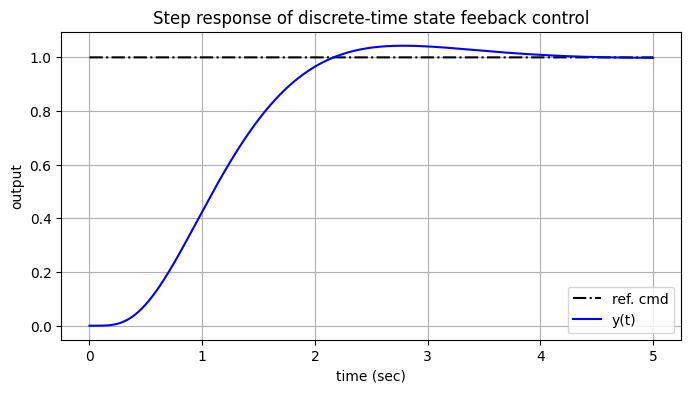

In [95]:
# step response of discrete-time state feedback system
tvec = np.arange(0,5,Ts)
r = np.ones(tvec.shape)
rdc = Kdsf*np.ones(tvec.shape)
_, ydsf = ctl.forced_response(Tdsf_ss, tvec, rdc)
plt.figure(figsize=(8,4))
plt.plot(tvec,r,'k-.',tvec,ydsf,'b-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(["ref. cmd","y(t)"])
plt.title('Step response of discrete-time state feeback control')
plt.show()


การจำลองตัวควบคุมป้อนกลับเอาต์พุตในระบบเวลาวิยุตสามารถทำได้โดยวิธีการเช่นเดิม

In [96]:
num_states = Ad.shape[0]
Ad_cl_upper = np.hstack((Ad-Bd@Kd, Bd@Kd))
Ad_cl_lower = np.hstack((np.zeros((num_states,num_states)),Ad - Ld@Cd))
Ad_cl = np.vstack((Ad_cl_upper,Ad_cl_lower))
Bd_cl = np.vstack((Bd*Kdsf,np.zeros((num_states,1))))
Cd_cl = np.hstack((Cd,np.zeros((1,num_states))))
Dd_cl = [0]
Tdss_cl = ctl.ss(Ad_cl, Bd_cl, Cd_cl, Dd_cl,Ts)

ตรวจสอบเสถียรภาพของระบบวงปิดในเวลาวิยุต โพลทั้งหมดจะต้องอยู่ภายในวงกลมรัศมีหนึ่งหน่วย

In [97]:
abs(ctl.poles(Tdss_cl))

array([0.9900526 , 0.9900473 , 0.99007428, 0.99874079, 0.99874079,
       0.37117046, 0.22167124, 0.22167124, 0.07834637, 0.07834637])

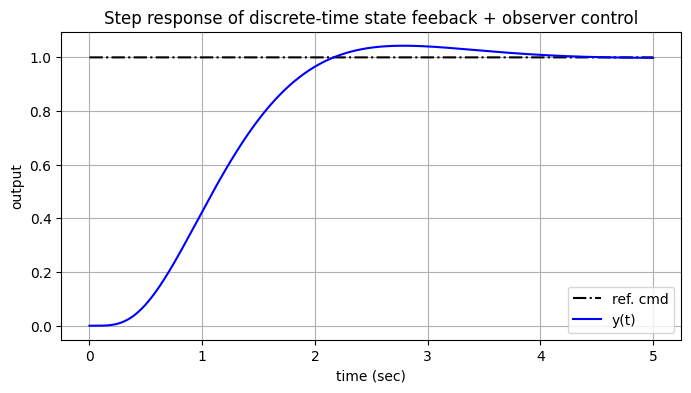

In [98]:
tdvec = np.arange(0,5,Ts)
rd = np.ones(tdvec.shape)
_, yd_sfo = ctl.step_response(Tdss_cl, tdvec)
plt.figure(figsize=(8,4))
plt.plot(tdvec,rd,'k-.',tdvec,yd_sfo,'b-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(["ref. cmd","y(t)"])
plt.title('Step response of discrete-time state feeback + observer control')
plt.show()

มาถึงจุดนี้เราพร้อมที่จะสร้างแผนภาพในรูปที่ 2 โดยใช้ Drake เพื่อทำให้เข้าใจแผนภาพได้ง่ายขึ้น 
จะวาดแผนภาพใหม่ที่ประกอบด้วยระบบย่อยดังในรูปที่ 3

!["fig 3"](https://raw.githubusercontent.com/dewdotninja/sharing-github/master/sfb_obs_diagram.png)

รูปที่ 3 แผนภาพของระบบควบคุมป้อนกลับเอาต์พุตที่ทำให้ง่ายขึ้น

แผนภาพนี้คือการผสมกันของระบบย่อยแบบสถิต เวลาต่อเนื่อง และเวลาวิยุตที่เราต้องนิยามขึ้น ส่วนระบบย่อยสำหรับสร้างอินพุตขั้นบันไดมีให้แล้วใน Drake

**หมายเหตุ :** ต้องแน่ใจว่า Drake ติดตั้งอย่างถูกต้องตามคำแนะนำจาก [Drake website](https://drake.mit.edu/) 

นำเข้า Drake API ที่ต้องการใช้


In [99]:
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder, BasicVector, LeafSystem
from pydrake.systems.primitives import LogVectorOutput, ConstantVectorSource, LinearSystem

เริ่มจากคลาสที่ง่ายสุดคือ ตัวควบคุมป้อนกลับสถานะที่เป็นแบบสถิต คือคลาสที่ไม่มีสถานะภายใน เอาต์พุตได้จากคำสั่งอ้างอิง 
ลบด้วยค่าป้อนกลับจากสถานะประมาณค่าคูณกับอัตราขยายป้อนกลับสถานะ ค่าของอัตราขยาย $K$ เป็นค่าเริ่มต้นที่กำหนดโดยอาร์กิวเมนต์
เช่นเดียวกับค่าอัตราขยายป้อนข้างหน้า (feedforward gain) $K_f$ ที่ช่วยให้เอาต์พุตของพลานต์เข้าสู่ค่า 1 

In [100]:
class StaticSFB(LeafSystem):
    def __init__(self,K, Kf):
        super().__init__()  # Don't forget to initialize the base class.
        self.nstates = K.shape[1]
        self.r = self.DeclareVectorInputPort(name="r", size=1)  # ref.cmd input
        self.xhat = self.DeclareVectorInputPort(name="xhat", size=self.nstates) # estimated state input
        self.DeclareVectorOutputPort(name="controlout", size=1, calc=self.CalcControlOutput)
        self.K = K  # state feedback gain
        self.Kf = Kf  # DC gain is needed so that output steps to 1

    def CalcControlOutput(self, context, output):
        r = self.r.Eval(context)  # evaluate ref.cmd
        xhat = self.xhat.Eval(context) # evaluate estimated state input
        u = self.Kf*r - self.K @ xhat
        output.SetFromVector(u)


ระบบย่อยที่สองที่จะสร้างขึ้นคือพลานต์ในระบบเวลาต่อเนื่อง โดยกำหนดค่าเมทริกซ์ A,B,C เป็นอาร์กิวเมนต์เริ่มต้น ความแตกต่างจากระบบสถิตก่อนหน้าคือ
เราต้องนิยามพลวัตของพลานต์ในเมธอด DoCalcTimeDerivatives() (ซื่อไม่สามารถเปลี่ยนได้) เราสามารถใส่พลวัตใดๆ 
แต่ในโจทย์นี้เป็นพลวัตเชิงเส้น xdot = Ax + Bu 

หลังจากนั้นนิยามเมธอดสำหรับคำนวณค่าเอาต์พุต คือ y = Cx (ในกรณีทั่วไปคือ y = Cx + Du 
แต่เนื่องจากเราทราบว่าพลานต์ในระบบกายภาพ D = 0 จึงไม่จำเป็นต้องใช้)

In [101]:
class CTPlant(LeafSystem):
    def __init__(self,A,B,C): # D is not needed since it is 0 for physical system
        super().__init__()
        num_state = A.shape[0] # extract proper dimension from A,B,C
        num_input = B.shape[1]
        num_output = C.shape[0]
        self.DeclareContinuousState(num_state)  # number of state variables.
        self.u = self.DeclareVectorInputPort("u",BasicVector(num_input))
        self.DeclareVectorOutputPort("y", BasicVector(num_output), self.CalcOutputY)
        # plant SS data
        self.A = A
        self.B = B
        self.C = C

    def DoCalcTimeDerivatives(self, context, derivatives):
        # get the state
        x = context.get_continuous_state_vector().CopyToVector()
        # get the input
        u = self.u.Eval(context)        
        xdot = self.A @ x + self.B @ u
        derivatives.get_mutable_vector().SetFromVector(xdot)

    def CalcOutputY(self, context, output):
        x = context.get_continuous_state_vector().CopyToVector()
        y = self.C @ x
        output.SetFromVector(y)

ระบบย่อยสุดท้ายคือตัวสังเกตที่เป็นแบบเวลาวิยุต มีความคล้ายกับคลาสในระบบเวลาต่อเนื่อง เพียงแต่พลวัตของสถานะเป็นสมการผลต่าง 
(difference equation) ซึ่งก็คือสมการของตัวสังเกต สังเกตว่าเราต้องกำหนดค่าคาบเวลาให้ด้วย สำหรับอาร์กิวเมนต์ self.all_state_ticket() 
ช่วยทำให้ไม่เกิด algebraic loop ในการจำลอง

In [102]:
class DTObserver(LeafSystem):
    def __init__(self,Ad,Bd,Cd,Ld, Ts):
        super().__init__()
        num_DTstate = Ad.shape[0] # extract proper dimension from A,B,C
        num_input1 = Bd.shape[1]
        num_input2 = Cd.shape[0]
        num_output = Ad.shape[0]
        self.Ad = Ad
        self.Bd = Bd
        self.Cd = Cd
        self.Ld = Ld  # estimator gain
        self.Ts = Ts  # sampling period

        
        self.DeclareDiscreteState(num_DTstate)  # num_state state variable.
        self.u = self.DeclareVectorInputPort("u", BasicVector(num_input1))  
        self.y = self.DeclareVectorInputPort("y", BasicVector(num_input2))  
        
        self.DeclareVectorOutputPort("xhat", BasicVector(num_output), 
                            self.CalcXhat, set([self.all_state_ticket()])) # last argument required to avoid
                                                                            # algebraic loop
        self.DeclarePeriodicDiscreteUpdateEvent(
            period_sec=self.Ts,  # sampling time
            offset_sec=0.0,  # The first event is at time zero.
            update=self.Update) # Call the Update method defined below.
    def Update(self, context, discrete_state):
        x = context.get_discrete_state_vector().CopyToVector()
        u = self.u.Eval(context)
        y = self.y.Eval(context)
        #x = np.mat(x.reshape((5,1)))
        xnext = (self.Ad - self.Ld@self.Cd)@x +self.Bd@u + self.Ld@y
        discrete_state.get_mutable_vector().SetFromVector(xnext)

    def CalcXhat(self, context, output):
        x = context.get_discrete_state_vector().CopyToVector()
        y = x  # just output the estimated state
        output.SetFromVector(y)

สร้างไดอะแกรมและต่ออินพุต/เอาต์พุตของแต่ละระบบย่อยเข้าด้วยกันตามรูปที่ 3 

In [103]:
builder = DiagramBuilder()
SFB_control = builder.AddSystem(StaticSFB(K,Kf))  # state-feedback subsystem
CT_plant = builder.AddSystem(CTPlant(A,B,C)) # continuous-time HDM plant
DT_observer = builder.AddSystem(DTObserver(Ad,Bd,Cd,Ld,Ts)) # discrete-time observer
stepInput = builder.AddSystem(ConstantVectorSource([1]))  # step-input. 
builder.Connect(stepInput.get_output_port(0), SFB_control.get_input_port(0)) # step input to SFB input 0
builder.Connect(DT_observer.get_output_port(0), SFB_control.get_input_port(1)) # observer output to SFB input 1
builder.Connect(SFB_control.get_output_port(0), CT_plant.get_input_port(0)) # SFB output to plant input 1
builder.Connect(SFB_control.get_output_port(0),DT_observer.get_input_port(0))  # SFB output to observer input 0
builder.Connect(CT_plant.get_output_port(0), DT_observer.get_input_port(1))  # plant output to observer input 1

logger_output = LogVectorOutput(CT_plant.get_output_port(0), builder)
logger_input = LogVectorOutput(stepInput.get_output_port(0), builder)
diagram = builder.Build()


ทำการจำลอง เก็บค่าของอินพุตและเอาต์พุตที่ต้องการ และใช้ matplotlib ในการพล็อตค่า

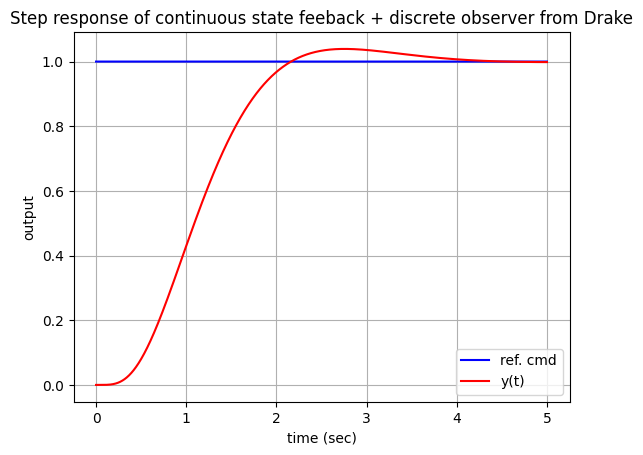

In [104]:


simulator = Simulator(diagram)
context = simulator.get_mutable_context()  # overall context 

# subsystem context 
plant_context = diagram.GetMutableSubsystemContext(CT_plant, context)
plant_context.SetContinuousState([0,0,0,0,0])
observer_context = diagram.GetMutableSubsystemContext(DT_observer, context)
observer_context.SetDiscreteState([0,0,0,0,0])

simulator.AdvanceTo(5)
log_output = logger_output.FindLog(context)
log_input = logger_input.FindLog(context)

# Plot the results.
plt.figure()
plt.plot(log_input.sample_times(),log_input.data().transpose(),'b-',
         log_output.sample_times(), log_output.data().transpose(),'r-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(["ref. cmd","y(t)"])
plt.title('Step response of continuous state feeback + discrete observer from Drake')
plt.show()

**เนื้อหาเสริม :** หากต้องการสร้างระบบย่อยของตัวสังเกตเป็นแบบเวลาต่อเนื่อง นิยามคลาสดังนี้

In [34]:
class CTObserver(LeafSystem):
    def __init__(self,A,B,C,L): # D is not needed since it is 0 for physical system
        super().__init__()
        num_state = A.shape[0] # extract proper dimension from A,B,C
        num_input1 = B.shape[1]
        num_input2 = C.shape[0]
        num_output = A.shape[0]
        self.DeclareContinuousState(num_state)  # number of state variables.
        self.u = self.DeclareVectorInputPort("u",BasicVector(num_input1))
        self.y = self.DeclareVectorInputPort("y",BasicVector(num_input2))
        self.DeclareVectorOutputPort("xhat", BasicVector(num_output), 
                                     self.CalcXhat,set([self.all_state_ticket()]))
        # plant SS data
        self.A = A
        self.B = B
        self.C = C
        self.L = L

    def DoCalcTimeDerivatives(self, context, derivatives):
        # get the state
        x = context.get_continuous_state_vector().CopyToVector()
        # get the input
        u = self.u.Eval(context)  
        y = self.y.Eval(context)
        xdot = (self.A - self.L@self.C)@x + self.B@u +self.L@y
        derivatives.get_mutable_vector().SetFromVector(xdot)

    def CalcXhat(self, context, output):
        x = context.get_continuous_state_vector().CopyToVector()
        y = x
        output.SetFromVector(y)

In [35]:
builder = DiagramBuilder()
SFB_control = builder.AddSystem(StaticSFB(K,Kf))  # state-feedback subsystem
CT_plant = builder.AddSystem(CTPlant(A,B,C)) # continuous-time HDM plant
CT_observer = builder.AddSystem(CTObserver(A,B,C,L)) # discrete-time observer
stepInput = builder.AddSystem(ConstantVectorSource([1]))  # step-input. 
builder.Connect(stepInput.get_output_port(0), SFB_control.get_input_port(0)) # step input to SFB input 0
builder.Connect(CT_observer.get_output_port(0), SFB_control.get_input_port(1)) # observer output to SFB input 1
builder.Connect(SFB_control.get_output_port(0), CT_plant.get_input_port(0)) # SFB output to plant input 1
builder.Connect(SFB_control.get_output_port(0),CT_observer.get_input_port(0))  # SFB output to observer input 0
builder.Connect(CT_plant.get_output_port(0), CT_observer.get_input_port(1))  # plant output to observer input 1

logger_output = LogVectorOutput(CT_plant.get_output_port(0), builder)
logger_input = LogVectorOutput(stepInput.get_output_port(0), builder)
diagram = builder.Build()

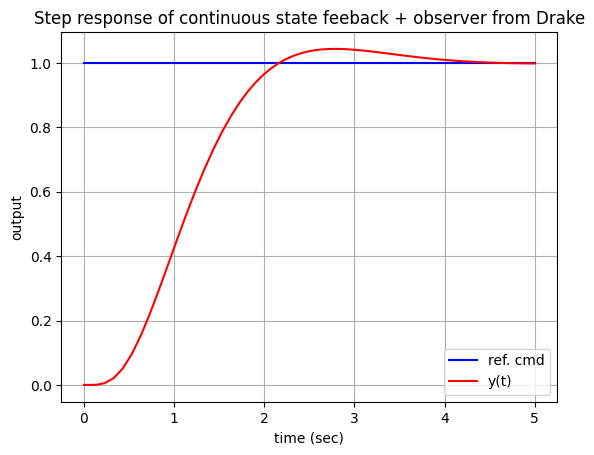

In [36]:
simulator = Simulator(diagram)
context = simulator.get_mutable_context()  # overall context 

# subsystem context 
plant_context = diagram.GetMutableSubsystemContext(CT_plant, context)
plant_context.SetContinuousState([0,0,0,0,0])
observer_context = diagram.GetMutableSubsystemContext(CT_observer, context)
observer_context.SetContinuousState([0,0,0,0,0])
# create the simulator
#simulator = Simulator(diagram, context)
simulator.AdvanceTo(5)
log_output = logger_output.FindLog(context)
log_input = logger_input.FindLog(context)

# Plot the results.
plt.figure()
plt.plot(log_input.sample_times(),log_input.data().transpose(),'b-',
         log_output.sample_times(), log_output.data().transpose(),'r-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(["ref. cmd","y(t)"])
plt.title('Step response of continuous state feeback + observer from Drake')
plt.show()

<div align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</div>
<div align="center">dew.ninja 2024</div>